# 0 Configuration

In [1]:
config = {
    "overview": {

    },
    "fe": {
        "id": False, # true
        "volume": False,
        "order_purchase_timestamp": False, # linked with 'shipping_limit_date'
        "shipping_limit_date": False,
        "order_estimated_delivery_date": False,
        "price_agg": False, # false
        "last_order_datetime": False,
        "frequency": False
    },
    "model": {
        "rfm_raw": {
            "preparation": False,
            "n_cluster": False,
            "silhouette": False,
            "explain": False,
            "persona": False
        },

    },
    "geo": {
        "preproc": False,
        "arange": False,
        "all": False,
        "per_cluster": False
    },
    "global": {
        "do": True,
        "elbow": False,
        "explain_plot": False,
        "features_plot": False,
        "cluster_plot": False
    },
    "maintenance": {
        "do": True
    }
}

***
# 1 Dependencies import

## 1.0 Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

from math import ceil

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(0)

***
## 1.1 Features selection

In [3]:
def get_categorical_features_name(dataset, split_by_unique_count=True, split_count=10):
    features_name = dataset.select_dtypes(["object", "bool"]).columns
    if split_by_unique_count:
        less_uniques = [feature_name for feature_name in features_name if dataset[feature_name].nunique() <= split_count]
        lot_uniques = features_name.difference(less_uniques).tolist()
        return (less_uniques, lot_uniques)
    else:
        return features_name.values.tolist()

In [4]:
def get_numerical_features_name(dataset):
    features_name = dataset.select_dtypes(["int64", "float64"]).columns.values.tolist()
    return features_name

In [5]:
def progressiveFeatureSelection(df, n_clusters=3, max_features=4,):
    feature_list = list(df.columns)
    selected_features = list()
    # select starting feature
    initial_feature = ""
    high_score = 0
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = df[feature]
        labels = kmeans.fit_predict(data_.to_frame())
        score_ = silhouette_score(data_.to_frame(), labels)
        print("Proposed new feature {} with score {}". format(feature, score_))
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    print("The initial feature is {} with a silhouette score of {}.".format(initial_feature, high_score))
    feature_list.remove(initial_feature)
    selected_features.append(initial_feature)
    for _ in range(max_features-1):
        high_score = 0
        selected_feature = ""
        print("Starting selection {}...".format(_))
        for feature in feature_list:
            selection_ = selected_features.copy()
            selection_.append(feature)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            print("Proposed new feature {} with score {}". format(feature, score_))
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        selected_features.append(selected_feature)
        feature_list.remove(selected_feature)
        print("Selected new feature {} with score {}". format(selected_feature, high_score))
    return selected_features

***
## 1.2 Pipeline construction

In [6]:
def evaluate(dataset, model, scoring="neg_root_mean_squared_error"):

    ### DATASET PREPARATION ###

    # categorical_cols = get_categorical_features_name(dataset, split_by_unique_count=False)
    numerical_cols = get_numerical_features_name(dataset)

    # X = dataset[numerical_cols + categorical_cols]
    X = dataset[numerical_cols]

    ### PIPELINE CONSTRUCTION ###

    num_pipe = Pipeline(steps=[
        ("simple_imputer", SimpleImputer(strategy="mean")),
        ("minmax_scaler", StandardScaler())
    ])

    # cat_pipe = Pipeline(steps=[
    #     ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    #     ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    #     ("simple_imputer_bis", SimpleImputer(strategy="mean")),
    #     ("std_scaler", StandardScaler())
    # ])

    preprocessor = ColumnTransformer([
        ("num_pipe", num_pipe, numerical_cols),
        # ("cat_pipe", cat_pipe, categorical_cols)
    ])

    pipeline = Pipeline([
        ("transforms", preprocessor),
        ("model", model)
    ])

    preprocessor.fit(X)
    array_preproc = preprocessor.transform(X)
    data_preproc = pd.DataFrame(data=array_preproc, columns=X.columns)

    return pipeline, preprocessor, data_preproc

In [7]:
def pca_preprocessor(dataset):
    num_cols = get_numerical_features_name(dataset)
    categ_cols, _ = get_categorical_features_name(dataset)

    num_pipe = Pipeline(steps=[
        ("imputer_01", SimpleImputer(strategy="mean")),
        ("scaler_01", StandardScaler())
    ])

    categ_pipe = Pipeline(steps=[
        ("imputer_01", SimpleImputer(strategy="most_frequent")),
        ("encoder_01", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num_pipe", num_pipe, num_cols),
        ("categ_pipe", categ_pipe, categ_cols)
    ])

    return preprocessor, num_cols, categ_cols

In [8]:
def preprocess_data(dataset):
    preprocessor, num_cols, categ_cols = pca_preprocessor(dataset)

    raw_preprocessed_data = preprocessor.fit_transform(dataset)

    if categ_cols:
        categ_cols_preprocessed = preprocessor.transformers_[1][1]["encoder_01"].get_feature_names_out(categ_cols).tolist()
    else:
        categ_cols_preprocessed = []

    col_names = num_cols + categ_cols_preprocessed

    preprocessed_data = pd.DataFrame(data=raw_preprocessed_data, columns=col_names)

    return preprocessed_data

***
## 1.3 Cluster evaluation

In [9]:
def elbow_plot(range, data, figsize=(10,10)):
    intertia_list = []
    for n in range:
        kmeans = KMeans(n_clusters=n, random_state=1)
        kmeans.fit(data)
        intertia_list.append(kmeans.inertia_)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=intertia_list, x=range, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range))
    fig.show()

In [10]:
def silhouette_plot(range, data, n_cols=2, figsize=(20, 10), wspace=0.35, hspace=0.35):
    if range[0] == 0:
        raise Exception("Range must not include 0")

    n_rows = ceil(len(range)/n_cols)
    index = 0

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    for n in range:
        kmeans = KMeans(n, random_state=1)

        plt.subplot(n_rows, n_cols, index+1)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick")
        sv.fit(data)

        index += 1
    
    plt.show()

In [11]:
def find_optimal_epsilon(n_neighbors, data):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [12]:
def display_clusters(dataset_preproc, n_clusters):
    pca, pca_data, loadings = apply_pca(dataset_preproc, dataset_preproc.columns, 2)
    reduced_data = pca_data.to_numpy()
    model = KMeans(init="k-means++", n_clusters=n_clusters)
    model.fit(reduced_data)

    h = 0.02

    x_min = reduced_data[:, 0].min() - 1
    x_max = reduced_data[:, 0].max() + 1

    y_min = reduced_data[:, 1].min() - 1
    y_max = reduced_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z, interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower"
    )

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

    centroids = model.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10
    )

    plt.title("K-means clustering, PCA reduced dataset")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

***
## 1.4 Dimensionality reduction

In [13]:
def scree_plot(dataset, figsize=(15, 5)):
    pca = PCA()
    pca.fit(dataset)

    plt.figure(figsize=figsize)
    explain_variance = pd.Series(pca.explained_variance_ratio_)
    explain_variance.plot(kind="bar", alpha=0.7)

    total = 0
    var_ls = []
    for x in explain_variance:
        total = total + x
        var_ls.append(total)
    
    pd.Series(var_ls).plot(marker="o", alpha=0.7)
    plt.xlabel("Principle Components", fontsize="x-large")
    plt.ylabel("Percentage Variance Explained", fontsize="x-large")
    plt.title("Scree plot", fontsize="xx-large")
    plt.show()

    return pca

In [14]:
def apply_pca(dataset, columns, n_components):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(dataset[columns])
    components_name = [f"PC{i+1}" for i in range(pca_data.shape[1])]
    pca_data = pd.DataFrame(data=pca_data, columns=components_name)
    loadings = pd.DataFrame(data=pca.components_.T, columns=components_name, index=columns)
    return pca, pca_data, loadings

In [15]:
def plot_variance(pca, width=8, dpi=100):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_

    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )

    cumulative_variance = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cumulative_variance], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )

    fig.set(figwidth=8, dpi=100)
    return axs

***
## 1.5 RFM

In [16]:
def rfm_distplot(dataset, customer_id, figsize=(20, 5)):
    warnings.filterwarnings('ignore')
    dataset = dataset.loc[:, dataset.columns.difference(customer_id)]

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    for i, feature in enumerate(dataset.columns):
        sns.distplot(dataset[feature], ax=axes[i])

In [17]:
def correlation_heatmap(dataset, figsize=(30, 20)):
    plt.figure(figsize=figsize)

    correlation = dataset.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title("Correlation heatmap", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.show()

In [18]:
def elbow(dataset, k=(2, 12)):
    model = KMeans(random_state=1)
    elbow_visualizer = KElbowVisualizer(model, k=k)

    elbow_visualizer.fit(dataset)
    elbow_visualizer.poof()

In [19]:
def silhouette(dataset, n):
    model = KMeans(n, random_state=1)
    silhouette_visualizer = SilhouetteVisualizer(model)

    silhouette_visualizer.fit(dataset)
    silhouette_visualizer.poof()

In [20]:
def explain(dataset, dataset_preproc):
    model = KMeans(n_clusters=4, random_state=1).fit(dataset_preproc)
    data_explain = dataset
    data_explain["Cluster"] = model.labels_

    data_explain_melt = pd.melt(data_explain, id_vars=["customer_id", "Cluster"], value_vars=["Récence", "Fréquence", "Montant"], var_name="Features", value_name="Value")
    sns.lineplot("Features", "Value", hue="Cluster", data=data_explain_melt)
    plt.legend()

    return data_explain.groupby("Cluster").agg({
    "Récence": ["mean", "min", "max"],
    "Fréquence": ["mean", "min", "max"],
    "Montant": ["mean", "min", "max", "count"]
})

***
## 1.6 Explainability

In [21]:
def explain_global(dataset, dataset_preproc, clusters, figsize=(30, 10)):
    model = KMeans(n_clusters=clusters, random_state=1).fit(dataset_preproc)
    data_explain = dataset_preproc.copy()
    data_explain.loc[:, "customer_id"] = dataset.loc[:, "customer_id"]
    data_explain.loc[:, "Cluster"] = model.labels_

    data_explain_melt = pd.melt(data_explain, id_vars=["customer_id", "Cluster"], value_vars=dataset_preproc.columns, var_name="Features", value_name="Value")

    plt.figure(figsize=figsize)
    sns.lineplot(x="Features", y="Value", hue="Cluster", data=data_explain_melt, palette="deep")
    plt.legend()

    ops = {}
    for col in dataset_preproc.columns:
        ops[col] = ["mean", "min", "max", "count"]

    return data_explain.groupby("Cluster").agg(ops)

***
# 2 Data loading

In [22]:
data = pd.read_csv("data/data_cleaned.csv", delimiter=",")

In [23]:
# data = pd.read_csv("data/data_cleaned.csv", delimiter=",", parse_dates=["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date", "review_creation_date", "review_answer_timestamp", "shipping_limit_date"], infer_datetime_format=True)

***
# 3 Overview

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111705 entries, 0 to 111704
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       111705 non-null  object 
 1   customer_id                    111705 non-null  object 
 2   order_status                   111705 non-null  object 
 3   order_purchase_timestamp       111705 non-null  object 
 4   order_approved_at              111690 non-null  object 
 5   order_delivered_carrier_date   110530 non-null  object 
 6   order_delivered_customer_date  109366 non-null  object 
 7   order_estimated_delivery_date  111705 non-null  object 
 8   customer_unique_id             107697 non-null  object 
 9   customer_zip_code_prefix       107697 non-null  float64
 10  customer_city                  107697 non-null  object 
 11  customer_state                 107697 non-null  object 
 12  review_id                     

In [25]:
data.describe()

,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix
count,107697.000000,111705.000000,111705.000000,111702.000000,111705.00000,111705.000000,111705.000000,111323.000000,110116.000000,110116.000000,110116.000000,111679.000000,111687.000000,111687.000000,111687.000000,111705.000000
mean,35174.843524,4.033597,1.022640,3.000116,177.04113,1.195273,120.556914,20.057779,48.776390,787.762478,2.209988,2092.554187,30.143616,16.586111,22.994332,24447.946896
std,29885.219509,1.387014,0.256334,2.794302,269.13137,0.689177,182.507246,15.788333,10.025996,651.996358,1.721755,3750.548184,16.141022,13.442283,11.706423,27605.113502
min,1003.000000,1.000000,1.000000,1.000000,0.01000,1.000000,0.850000,0.010000,5.000000,4.000000,1.000000,2.000000,7.000000,2.000000,6.000000,1001.000000
25%,11340.000000,4.000000,1.000000,1.000000,64.01000,1.000000,39.900000,13.085000,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000
50%,24350.000000,5.000000,1.000000,2.000000,112.42000,1.000000,74.990000,16.290000,52.000000,602.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13566.000000
75%,59075.000000,5.000000,1.000000,4.000000,193.32000,1.000000,134.900000,21.160000,57.000000,986.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28035.000000
max,99990.000000,5.000000,27.000000,24.000000,13664.08000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000


In [26]:
data.describe(include="object")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,review_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_type,product_id,seller_id,shipping_limit_date,product_category_name,seller_city,seller_state
count,111705,111705,111705,111705,111690,110530,109366,111705,107697,107697,107697,111705,13416,47402,111705,111705,111705,111705,111705,111705,110116,111705,111705
unique,97916,97916,7,97370,89533,80449,95021,449,94655,4107,27,97454,4495,35618,632,97292,4,32789,3090,92642,73,611,23
top,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2018-02-24 03:20:27,2018-05-09 15:48:00,2017-07-31 18:03:02,2017-12-20 00:00:00,4546caea018ad8c692964e3382debd19,sao paulo,SP,e8236fe7b6e1bdd513a500de361e2b87,Recomendo,Muito bom,2017-12-19 00:00:00,2017-07-30 14:19:07,credit_card,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,cama_mesa_banho,sao paulo,SP
freq,21,21,109367,21,23,48,21,600,21,16966,45365,21,468,253,513,21,84471,524,2014,21,10982,27745,79661


***
# 4 Feeture engineering

## 4.0 Remove *_id

In [27]:
def fe_id_remove(dataset, diff=[]):
    id_cols = dataset.columns[dataset.columns.str.contains("_id")]
    id_cols = id_cols.difference(diff)
    dataset.drop(columns=id_cols, inplace=True)
    return dataset

***
## 4.1 Volume

In [28]:
def fe_volume(dataset):
    dataset["product_volume_cm3"] = dataset["product_length_cm"] * dataset["product_height_cm"] * dataset["product_width_cm"]
    return dataset

***
## 4.2 Order purchase timestamp

In [29]:
def fe_purchase_timestamp(dataset):
    dataset.loc[:, "order_purchase_timestamp"] = dataset.loc[:, "order_purchase_timestamp"].apply(pd.to_datetime)
    opt = dataset.loc[:, "order_purchase_timestamp"]
    dataset["order_purchase_year"] = opt.dt.year
    dataset["order_purchase_month"] = opt.dt.month
    dataset["order_purchase_day"] = opt.dt.day
    dataset["order_purchase_hour"] = opt.dt.hour

    display = dataset.loc[:, ["order_purchase_timestamp", "order_purchase_year", "order_purchase_month", "order_purchase_day", "order_purchase_hour"]].head()
    return dataset

***
## 4.3 Shipping limit date

In [30]:
def fe_shipping_date(dataset):
    dataset.loc[:, "shipping_limit_date"] = dataset.loc[:, "shipping_limit_date"].apply(pd.to_datetime)
    sld = dataset.loc[:, "shipping_limit_date"]
    dataset["shipping_limit_year"] = sld.dt.year
    dataset["shipping_limit_month"] = sld.dt.month
    dataset["shipping_limit_day"] = sld.dt.day
    dataset["shipping_limit_hour"] = sld.dt.hour

    display = dataset.loc[:, ["shipping_limit_date", "shipping_limit_year", "shipping_limit_month", "shipping_limit_day", "shipping_limit_hour"]].head()
    return dataset

***
## 4.4 Estimated delivery date

In [31]:
def fe_delivery_date(dataset):
    dataset.loc[:, "order_estimated_delivery_date"] = dataset.loc[:, "order_estimated_delivery_date"].apply(pd.to_datetime)
    oedd = dataset.loc[:, "order_estimated_delivery_date"]
    dataset["order_estimated_delivery_year"] = oedd.dt.year
    dataset["order_estimated_delivery_month"] = oedd.dt.month
    dataset["order_estimated_delivery_day"] = oedd.dt.day
    dataset["order_estimated_delivery_hour"] = oedd.dt.hour

    display = dataset.loc[:, ["order_estimated_delivery_date", "order_estimated_delivery_year", "order_estimated_delivery_month", "order_estimated_delivery_day", "order_estimated_delivery_hour"]].head()
    return dataset

***
## 4.5 Price agg

In [32]:
def fe_price(dataset):
    customer_price_agg = dataset.groupby("customer_id").agg({
        "price": ["min", "max", "mean", "sum"]
    })

    customer_price_agg.rename(columns={
        "min": "price_min",
        "max": "price_max",
        "mean": "price_mean",
        "sum": "price_sum"
    }, inplace=True)

    dataset = dataset.merge(customer_price_agg.price, on="customer_id")
    display = dataset.loc[:, ["customer_id", "price_min", "price_max", "price_mean", "price_sum"]].head()
    return dataset


***
## 4.6 Last order datetime

In [33]:
def fe_recency(dataset):
    dataset.loc[:, "order_purchase_timestamp"] = dataset.loc[:, "order_purchase_timestamp"].apply(pd.to_datetime)
    data_end = max(dataset.loc[:, "order_purchase_timestamp"] + pd.Timedelta(days=1))

    opt_agg = dataset.groupby("customer_id").agg({
        "order_purchase_timestamp": lambda x: (data_end - max(x)).days
    })

    opt_agg.columns = ["recency"]
    opt_agg = opt_agg.reset_index()

    dataset = dataset.merge(opt_agg, on="customer_id")

    display = dataset.loc[:, ["customer_id", "order_purchase_timestamp", "recency"]].head()
    return dataset

***
## 4.7 Frequency

In [34]:
def fe_frequency(dataset):
    frequency = dataset.groupby("customer_id").agg({
        "order_id": ["count"]
    })

    frequency = frequency.order_id.reset_index()
    frequency.columns = ["customer_id", "frequency"]
    
    dataset = dataset.merge(frequency, how="left", on="customer_id")
    display = dataset.loc[:, ["customer_id", "frequency"]].head()
    return dataset

***
# 5 Modelisation

## 5.1 RFM

### 5.1.1 Preparation

RFM: Récence (dat de la dernière commande), Fréquence (des commandes), Montant (de la dernière commande ou sur une période donnée)

In [35]:
if config["model"]["rfm_raw"]["preparation"]:
    rfm_cols = ["customer_id","order_purchase_timestamp", "order_id", "price"]
    data_rfm = data.loc[:, rfm_cols]

In [36]:
if config["model"]["rfm_raw"]["preparation"]:
    data_rfm = fe_id_remove(data_rfm, diff=["customer_id", "order_id", "product_id"])
    data_rfm = fe_recency(data_rfm)
    data_rfm = fe_price(data_rfm)
    data_rfm = fe_frequency(data_rfm)

In [37]:
if config["model"]["rfm_raw"]["preparation"]:
    data_rfm.drop(columns=["price", "price_min", "price_max", "price_mean", "order_purchase_timestamp", "order_id"], inplace=True)
    data_rfm.rename(columns={"recency": "Récence", "price_sum": "Montant", "frequency": "Fréquence"}, inplace=True)

In [38]:
display = None
if config["model"]["rfm_raw"]["preparation"]:
    display = data_rfm.describe()
display

In [39]:
if config["model"]["rfm_raw"]["preparation"]:
    rfm_distplot(data_rfm, ["customer_id"])

In [40]:
if config["model"]["rfm_raw"]["preparation"]:
    correlation_heatmap(data_rfm, figsize=(20, 5))

In [41]:
if config["model"]["rfm_raw"]["preparation"]:

    model = KMeans(n_clusters=4)

    pipeline, preproc, data_preproc = evaluate(data_rfm, model)

In [42]:
display = None
if config["model"]["rfm_raw"]["preparation"]:
    display = data_preproc.head()
display

In [43]:
if config["model"]["rfm_raw"]["preparation"]:
    rfm_distplot(data_preproc, ["customer_id"])

***
### 5.1.2 Cluster N analysis

In [44]:
if config["model"]["rfm_raw"]["n_cluster"]:
    elbow(data_preproc.copy(), (2, 12))

In [45]:
if config["model"]["rfm_raw"]["silhouette"]:
    silhouette(data_preproc.copy(), 4)

Silhouette for n=4  
![alt text](plots/kmeans_4n.png "Silhouette for n=4")

***
### 5.1.3 Explaination

In [46]:
display = None
if config["model"]["rfm_raw"]["explain"]:
    display = explain(data_rfm, data_preproc)
display

In [47]:
if config["model"]["rfm_raw"]["explain"]:
    pred = KMeans(n_clusters=4, random_state=1).fit_predict(data_preproc)

In [48]:
if config["model"]["rfm_raw"]["explain"]:
    plt.subplots(3, 3, figsize=(30, 15))
    plt.subplots_adjust(wspace=0.15, hspace=0.15)

    plt.subplot(3 ,3, 1)
    sns.scatterplot(x=data_rfm["Récence"], y=data_rfm["Récence"], hue=pred, palette="deep")

    plt.subplot(3 ,3, 2)
    sns.scatterplot(x=data_rfm["Récence"], y=data_rfm["Fréquence"], hue=pred, palette="deep")

    plt.subplot(3 ,3, 3)
    sns.scatterplot(x=data_rfm["Récence"], y=data_rfm["Montant"], hue=pred, palette="deep")

    plt.subplot(3 ,3, 4)
    sns.scatterplot(x=data_rfm["Fréquence"], y=data_rfm["Récence"], hue=pred, palette="deep")

    plt.subplot(3 ,3, 5)
    sns.scatterplot(x=data_rfm["Fréquence"], y=data_rfm["Fréquence"], hue=pred, palette="deep")

    plt.subplot(3 ,3, 6)
    sns.scatterplot(x=data_rfm["Fréquence"], y=data_rfm["Montant"], hue=pred, palette="deep")

    plt.subplot(3 ,3, 7)
    sns.scatterplot(x=data_rfm["Montant"], y=data_rfm["Récence"], hue=pred, palette="deep")

    plt.subplot(3 ,3, 8)
    sns.scatterplot(x=data_rfm["Montant"], y=data_rfm["Fréquence"], hue=pred, palette="deep")

    plt.subplot(3 ,3, 9)
    sns.scatterplot(x=data_rfm["Montant"], y=data_rfm["Montant"], hue=pred, palette="deep")

In [49]:
if config["model"]["rfm_raw"]["explain"]:
    display_clusters(data_preproc)

In [50]:
if config["model"]["rfm_raw"]["explain"]:
    loadings

In [51]:
if config["model"]["rfm_raw"]["explain"]:
    plot_variance(pca)

***
### 5.1.4 Persona

In [52]:
if config["model"]["rfm_raw"]["persona"]:
    display

In [53]:
if config["model"]["rfm_raw"]["persona"]:
    data_preproc["cluster"] = pred
    data_preproc["order_purchase_timestamp"] = data["order_purchase_timestamp"]
    data_preproc = fe_purchase_timestamp(data_preproc)

In [54]:
if config["model"]["rfm_raw"]["persona"]:
    data_preproc.head()

In [55]:
if config["model"]["rfm_raw"]["persona"]:
    plt.figure(figsize=(20, 10))
    sns.kdeplot(data=data_preproc, x="order_purchase_month", hue="cluster", shade=False, palette="deep")

In [56]:
if config["model"]["rfm_raw"]["persona"]:
    data_preproc["product_category_name"] = data["product_category_name"]

In [57]:
if config["model"]["rfm_raw"]["persona"]:
    data_preproc.head()

In [58]:
if config["model"]["rfm_raw"]["persona"]:
    tmp = data_preproc.groupby("cluster").agg({
        "product_category_name": "value_counts"
    })

In [59]:
if config["model"]["rfm_raw"]["persona"]:
    tmp.info()

In [60]:
if config["model"]["rfm_raw"]["persona"]:
    tmp.head()

In [61]:
if config["model"]["rfm_raw"]["persona"]:
    plt.figure(figsize=(30, 10))
    sns.countplot(data=data_preproc, x="product_category_name", hue="cluster", palette="deep")

#### Cluster 0 - Persona 1 - Anciens

Dernier achat: il y a plus de 1 an  
Nombre d'achats: 1.2  
Montant: 122€  
Population: 45 156 / 40.42%  

Actions:  
...


#### Cluster 1 - Persona 2 - Fidèle

Dernier achat: il y a 8 mois  
Nombre d'achats: 5.4  
Montant: 358€  
Population: 4 659 / 4.17%  


#### Cluster 2 - Persona 3 - Nouveaux

Dernier achat: il y a 4 mois  
Nombre d'achats: 1.2  
Montant: 122€  
Population: 60 284 / 53.96%  


#### Cluster 3 - Persona 4 - Fort potentiel

Dernier achat: il y a 8 mois  
Nombre d'achats: 1.7  
Montant: 819€  
Population: 1 606 / 1.43%  

Actions:  
Client à fort potentiel. Mise en place d'une action de fidélisation nécessaire.  

***
## 5.2 Global

In [62]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149.0,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1.0,18.12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366.0,sao paulo,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,1,credit_card,3.0,37.77,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290.0,sao paulo,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,1,credit_card,1.0,37.77,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,e781fdcc107d13d865fc7698711cc572,88032.0,florianopolis,SC,1bafb430e498b939f258b9c9dbdff9b1,3,NaN,NaN,2017-11-08 00:00:00,2017-11-10 19:52:38,1,boleto,1.0,44.09,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23 00:00:00,02c9e0c05a817d4562ec0e8c90f29dba,8577.0,itaquaquecetuba,SP,b8238c6515192f8129081e17dc57d169,5,NaN,"custo beneficio, simples de usar e rápido",2017-08-17 00:00:00,2017-08-21 12:43:27,1,credit_card,1.0,83.69,1,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-16 13:50:09,75.90,7.79,bebes,58.0,398.0,3.0,238.0,20.0,10.0,15.0,9350,maua,SP


In [63]:
display = None

if config["global"]["do"]:
    global_cols = data.select_dtypes(["int64", "float64"]).columns
    global_cols = global_cols.append(data.loc[:, ["customer_id", "order_id", "order_purchase_timestamp", "shipping_limit_date", "order_estimated_delivery_date"]].columns)

    global_data = data[global_cols]

    global_data = fe_volume(global_data)
    global_data = fe_price(global_data)
    global_data = fe_frequency(global_data)
    global_data = fe_recency(global_data)
    global_data = fe_shipping_date(global_data)
    global_data = fe_delivery_date(global_data)

    global_data_preproc = preprocess_data(global_data)

    display = global_data_preproc.head()

display

/tmp/ipykernel_94816/893303093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["product_volume_cm3"] = dataset["product_length_cm"] * dataset["product_height_cm"] * dataset["product_width_cm"]


,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,product_volume_cm3,price_min,price_max,price_mean,price_sum,frequency,recency,shipping_limit_year,shipping_limit_month,shipping_limit_day,shipping_limit_hour,order_estimated_delivery_year,order_estimated_delivery_month,order_estimated_delivery_day,order_estimated_delivery_hour
0,-1.091392,-0.024223,-0.088323,-0.715797,-0.590499,-0.283344,-0.496240,-0.719345,-0.881661,-0.802921,1.047123,-0.424670,-0.69045,-0.638793,-0.853820,-0.546928,-0.566960,-0.491182,-0.501271,-0.497775,-0.478889,-0.357791,0.590524,-1.095879,1.207185,-1.157916,-0.244298,-1.183117,1.195954,0.261557,0.0
1,-1.083997,-0.024223,-0.088323,-0.000042,-0.517486,-0.283344,-0.496240,-0.778985,-0.881661,-0.802921,1.047123,-0.424670,-0.69045,-0.638793,-0.853820,-0.546928,-0.566960,-0.491182,-0.501271,-0.497775,-0.478889,-0.357791,0.903891,-1.095879,0.585614,0.576697,1.109636,-1.183117,0.556093,1.403438,0.0
2,-1.120665,0.696754,-0.088323,-0.715797,-0.517486,-0.283344,-0.496240,-0.778985,-0.881661,-0.802921,1.047123,-0.424670,-0.69045,-0.638793,-0.853820,-0.546928,-0.566960,-0.491182,-0.501271,-0.497775,-0.478889,-0.357791,0.988761,-1.095879,0.585614,-0.926634,0.808762,-1.183117,0.556093,-0.081008,0.0
3,1.801291,-0.745200,-0.088323,-0.715797,-0.494003,-0.283344,-0.496240,-0.378002,-0.881661,-0.802921,1.047123,-0.424670,-0.69045,-0.638793,-0.853820,-0.546928,-0.566960,-0.491182,-0.501271,-0.497775,-0.478889,-0.357791,0.453425,-1.095879,1.207185,1.733105,-1.598231,-1.183117,1.515885,-0.309384,0.0
4,-0.906414,0.696754,-0.088323,-0.715797,-0.346862,-0.283344,-0.244687,-0.778351,0.926588,-0.602099,0.462142,-0.494535,-0.62849,-0.489996,-0.682959,-0.546928,-0.523148,-0.238547,-0.251678,-0.245444,-0.299444,-0.357791,0.936533,-1.095879,0.585614,-0.001507,0.056576,-1.183117,0.556093,0.832497,0.0


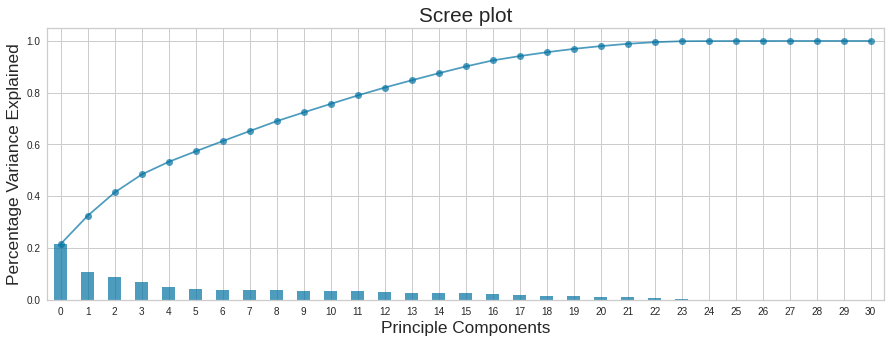

In [64]:
if config["global"]["do"]:
    pca = scree_plot(global_data_preproc)

In [65]:
if config["global"]["elbow"]:
    elbow(global_data_preproc)

In [66]:
display = None
if config["global"]["explain_plot"]:
    explain_data = explain_global(global_data, global_data_preproc, 6)
    display = explain_data
display

In [67]:
if config["global"]["do"]:
    global_data_preproc.drop(columns=["customer_zip_code_prefix", "review_score", "payment_installments", "payment_value", "order_item_id", "product_name_lenght", "product_description_lenght", "product_photos_qty", "product_length_cm", "product_height_cm", "product_width_cm", "seller_zip_code_prefix", "shipping_limit_year", "shipping_limit_month", "shipping_limit_day", "shipping_limit_hour", "order_estimated_delivery_year", "order_estimated_delivery_month", "order_estimated_delivery_day", "order_estimated_delivery_hour", "payment_sequential", "price_min", "price_max", "price_mean"], inplace=True)

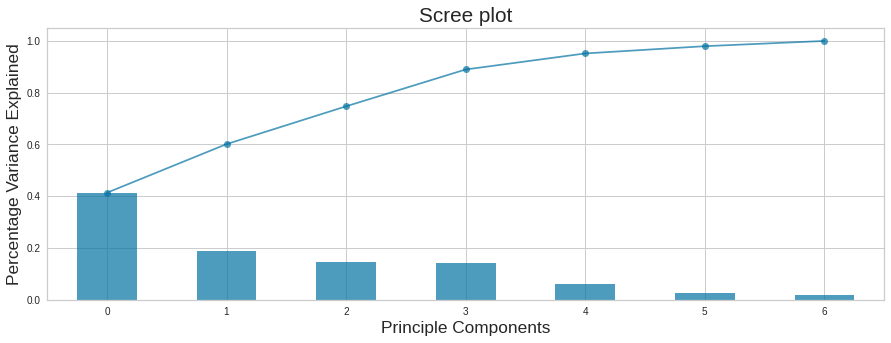

In [68]:
if config["global"]["do"]:
    pca = scree_plot(global_data_preproc)

In [69]:
if config["global"]["elbow"]:
    elbow(global_data_preproc)

In [70]:
display = None
if config["global"]["explain_plot"]:
    explain_data = explain_global(global_data, global_data_preproc, 12)
    display = explain_data
display

In [71]:
display = None
if config["global"]["explain_plot"]:
    explain_data = explain_global(global_data, global_data_preproc, 10)
    display = explain_data
display

In [72]:
display = None
if config["global"]["explain_plot"]:
    explain_data = explain_global(global_data, global_data_preproc, 8)
    display = explain_data
display

In [73]:
display = None
if config["global"]["explain_plot"]:
    explain_data = explain_global(global_data, global_data_preproc, 6)
    display = explain_data
display

In [74]:
if config["global"]["do"]:
    pred = KMeans(n_clusters=6, random_state=1).fit_predict(global_data_preproc)

Cluster description

|Cluster:|0|1|2|3|4|5|
|--------|-|-|-|-|-|-|
|price:|<span class="ml">medium-low</span>|<span class="l">low</span>|<span class="h">high</span>|<span class="l">low</span>|<span class="l">low</span>|<span class="m">medium</span>|
|freight_value:|<span class="m">medium</span>|<span class="l">low</span>|<span class="m">medium</span>|<span class="l">low</span>|<span class="l">low</span>|<span class="h">high</span>|
|weight:|<span class="mh">medium-high</span>|<span class="l">low</span>|<span class="ml">medium-low</span>|<span class="l">low</span>|<span class="l">low</span>|<span class="h">high</span>|
|volume:|<span class="mh">medium-high</span>|<span class="l">low</span>|<span class="ml">medium-low</span>|<span class="l">low</span>|<span class="l">low</span>|<span class="h">high</span>|
|price_sum:|<span class="ml">medium-low</span>|<span class="l">low</span>|<span class="h">high</span>|<span class="l">low</span>|<span class="ml">medium-low</span>|<span class="m">medium</span>|
|frequency:|<span class="l">low</span>|<span class="l">low</span>|<span class="l">low</span>|<span class="l">low</span>|<span class="h">high</span>|<span class="l">low</span>|
|recency:|<span class="m">medium</span>|<span class="l">low</span>|<span class="m">medium</span>|<span class="h">high</span>|<span class="m">medium</span>|<span class="m">medium</span>|

<style>
    .l {
        color: red;
    }

    .ml {
        color: orange;
    }

    .m {
        color: yellow
    }

    .mh {
        color: teal
    }

    .h {
        color: green
    }
</style>

We can deduce:  

Clusters 1 and 3 -> Losts  
Are very similar and are the leasts interesting clusters.  
Maybe low purchasing power customer ?

Cluster 4 -> Loyals  
Represent the clients who bought the more often.  
Middle class customer ?  
From town ?  

Cluster 5 -> Big articles  
Represents customers who bought heavy, big articles from far away sellers.  
Maybe for particular occasion, like a relocation ?  
Maybe customer from the countryside ?

Cluster 2 -> Best  
Represents customers who ave spent the most. The bought articles are small, light, most certainyl commonly bought.  
Big purchasing power ?  
From city ?  

Cluster 0 -> Potential  
Represents customers who ave not spent much but on bigger and heavier articles than average with average freight, so most commonly boughts articles.  
Maybe a lak of peticular articles ?

In [75]:
if config["global"]["features_plot"]:
    global_data["frequency"]

    nb_rows = 4

    plt.subplots(nb_rows, 3, figsize=(30, 15))
    plt.subplots_adjust(wspace=0.15, hspace=0.25)

    plt.subplot(nb_rows ,3, 1)
    sns.scatterplot(x=global_data["price"], y=global_data["price"], hue=pred, palette="deep")

    plt.subplot(nb_rows ,3, 2)
    sns.scatterplot(x=global_data["price"], y=global_data["frequency"], hue=pred, palette="deep")

    plt.subplot(nb_rows ,3, 3)
    sns.scatterplot(x=global_data["price"], y=global_data["recency"], hue=pred, palette="deep")

    plt.subplot(nb_rows ,3, 4)
    sns.scatterplot(x=global_data["frequency"], y=global_data["price"], hue=pred, palette="deep")

    plt.subplot(nb_rows ,3, 5)
    sns.scatterplot(x=global_data["frequency"], y=global_data["frequency"], hue=pred, palette="deep")

    plt.subplot(nb_rows ,3, 6)
    sns.scatterplot(x=global_data["frequency"], y=global_data["recency"], hue=pred, palette="deep")

    plt.subplot(nb_rows ,3, 7)
    sns.scatterplot(x=global_data["recency"], y=global_data["price"], hue=pred, palette="deep")

    plt.subplot(nb_rows ,3, 8)
    sns.scatterplot(x=global_data["recency"], y=global_data["frequency"], hue=pred, palette="deep")

    plt.subplot(nb_rows ,3, 9)
    sns.scatterplot(x=global_data["recency"], y=global_data["recency"], hue=pred, palette="deep")

    plt.subplot(nb_rows ,3, 10)
    sns.scatterplot(x=global_data["frequency"], y=global_data["product_volume_cm3"], hue=pred, palette="deep")

In [76]:
if config["global"]["cluster_plot"]:
    display_clusters(global_data_preproc, 6)

***
## 5.3 Geospatial analysis

### 5.3.1 Geoloc dataset preprocessing

In [77]:
import geopandas as gpd

In [78]:
re_write = False
if config["geo"]["preproc"]:
    geo_data = gpd.read_file("data/olist_geolocation_dataset.csv")

    geo_data["geolocation_lat"] = geo_data["geolocation_lat"].astype("float64")
    geo_data["geolocation_lng"] = geo_data["geolocation_lng"].astype("float64")

    geo_data["geolocation_lat"] = geo_data["geolocation_lat"].where(lambda x: x < 10, np.nan)
    geo_data.dropna(subset=["geolocation_lat"], inplace=True)

    geo_data = gpd.GeoDataFrame(geo_data, geometry=gpd.points_from_xy(geo_data["geolocation_lng"], geo_data["geolocation_lat"]))
    geo_data.to_file("data/olist_geolocation_dataset.json", driver="GeoJSON")

***
### 5.3.2 Base geoloc arrangment

In [79]:
if config["geo"]["arange"]:
    geo_data = gpd.read_file("data/olist_geolocation_dataset.json")

In [80]:
if config["geo"]["arange"]:
    geo_data.info()

In [81]:
if config["geo"]["arange"]:
    geo_data["geolocation_zip_code_prefix"] = geo_data["geolocation_zip_code_prefix"].astype("int64")

In [82]:
if config["geo"]["arange"]:
    geo_data.head()

In [83]:
if config["geo"]["arange"]:
    brazil_geo = gpd.read_file("data/brazil_geo.json")

In [84]:
if config["geo"]["arange"]:
    ax = brazil_geo.plot(figsize=(15, 15), color="none", edgecolor="gainsboro", zorder=3)
    geo_data.plot(color="blue", markersize=1, ax=ax)

***
### 5.3.2 Clustered geoloc points

In [85]:
if config["geo"]["all"]:
    global_data.loc[:, "Cluster"] = pred

In [86]:
if config["geo"]["all"]:
    global_data.info()

In [87]:
if config["geo"]["all"]:
    global_data.dropna(inplace=True)

In [88]:
if config["geo"]["all"]:
    global_data.loc[:, "customer_zip_code_prefix"] = global_data["customer_zip_code_prefix"].astype("int64")

In [89]:
if config["geo"]["all"]:
    global_data.head()

In [90]:
if config["geo"]["all"]:
    global_data["customer_zip_code_prefix"].value_counts().count()

In [91]:
if config["geo"]["all"]:
    by_customer_zip_code_prefix = global_data.groupby("Cluster")

In [92]:
if config["geo"]["all"]:
    by_customer_zip_code_prefix.head()

In [93]:
if config["geo"]["all"]:
    global_data_cleaned = global_data.loc[:, ["customer_zip_code_prefix", "seller_zip_code_prefix", "customer_id", "Cluster"]]
    geo_merged = geo_data.merge(global_data_cleaned, left_on="geolocation_zip_code_prefix", right_on="customer_zip_code_prefix")

In [94]:
if config["geo"]["all"]:
    geo_merged.head()

In [95]:
if config["geo"]["all"]:
    geo_merged.info()

In [96]:
if config["geo"]["all"]:
    geo_merged.drop_duplicates(subset=["geolocation_lng", "geolocation_lat"], inplace=True)

In [97]:
if config["geo"]["all"]:
    ax = brazil_geo.plot(figsize=(15, 15), color="none", edgecolor="gainsboro", zorder=3)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(data=geo_merged, x="geolocation_lng", y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)

***
### 5.3.3 Per cluster visualization

In [98]:
if config["geo"]["per_cluster"]:
    cluster_0 = geo_merged[geo_merged["Cluster"] == 0]
    cluster_1 = geo_merged[geo_merged["Cluster"] == 1] # useless
    cluster_2 = geo_merged[geo_merged["Cluster"] == 2]
    cluster_3 = geo_merged[geo_merged["Cluster"] == 3] # useless
    cluster_4 = geo_merged[geo_merged["Cluster"] == 4]
    cluster_5 = geo_merged[geo_merged["Cluster"] == 5]

    cluster_1_3 = geo_merged[(geo_merged["Cluster"] == 1) | (geo_merged["Cluster"] == 3)] # useless

In [99]:
if config["geo"]["per_cluster"]:
    plt.subplots(3, 2, figsize=(30, 30))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    ax = plt.subplot(3, 2, 1)
    brazil_geo.plot(color="none", edgecolor="gainsboro", zorder=3, ax=ax)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(data=cluster_0, x="geolocation_lng", y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)

    ax = plt.subplot(3, 2, 2)
    brazil_geo.plot(color="none", edgecolor="gainsboro", zorder=3, ax=ax)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(data=cluster_2, x="geolocation_lng", y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)

    ax = plt.subplot(3, 2, 3)
    brazil_geo.plot(color="none", edgecolor="gainsboro", zorder=3, ax=ax)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(data=cluster_4, x="geolocation_lng", y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)

    ax = plt.subplot(3, 2, 4)
    brazil_geo.plot(color="none", edgecolor="gainsboro", zorder=3, ax=ax)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(data=cluster_5, x="geolocation_lng", y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)

    ax = plt.subplot(3, 2, 5)
    brazil_geo.plot(color="none", edgecolor="gainsboro", zorder=3, ax=ax)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(data=cluster_1_3, x="geolocation_lng", y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)

***
## 5.4 Maintenance

In [100]:
from sklearn.metrics.cluster import adjusted_rand_score

In [112]:
if config["maintenance"]["do"]:
    global_data.loc[:, "order_purchase_timestamp"] = data.loc[:, "order_purchase_timestamp"]
    global_data.loc[:, "order_purchase_timestamp"] = global_data.loc[:, "order_purchase_timestamp"].apply(pd.to_datetime)

In [102]:
if config["maintenance"]["do"]:
    global_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111705 entries, 0 to 111704
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   customer_zip_code_prefix        107697 non-null  float64       
 1   review_score                    111705 non-null  int64         
 2   payment_sequential              111705 non-null  int64         
 3   payment_installments            111702 non-null  float64       
 4   payment_value                   111705 non-null  float64       
 5   order_item_id                   111705 non-null  int64         
 6   price                           111705 non-null  float64       
 7   freight_value                   111323 non-null  float64       
 8   product_name_lenght             110116 non-null  float64       
 9   product_description_lenght      110116 non-null  float64       
 10  product_photos_qty              110116 non-null  float64

In [113]:
if config["maintenance"]["do"]:
    global_data.head()

In [114]:
def get_entire_period(dataset, temporal_index):
    return ceil((dataset[temporal_index].max() - dataset[temporal_index].min())/np.timedelta64(1,'M'))

In [115]:
def get_frame_(dataset, temporal_index, start, period):
    temporal_index = dataset[temporal_index]
    end = start + pd.DateOffset(months=period)
    
    frame = dataset[(start <= temporal_index) & (temporal_index < end)]

    return frame

In [116]:
def kmeans_eval(dataset, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(dataset)
    labels = kmeans.labels_
    return labels

In [204]:
def rolling_eval_(dataset, features, temporal_index, n_clusters, initial_period, offset_month, key_index):
    entire_period = get_entire_period(dataset, temporal_index)
    begin = dataset[temporal_index].min()
    ari_scores = []

    ref_period = get_frame_(dataset=dataset.copy(), temporal_index=temporal_index, start=begin, period=initial_period)
    ref_period.drop_duplicates(subset=["customer_id"], inplace=True)

    ref_labels = kmeans_eval(dataset=ref_period[features], n_clusters=n_clusters)

    for offset in np.arange(0, entire_period, offset_month):
        current_period = get_frame_(dataset=dataset, temporal_index=temporal_index, start=begin, period=initial_period + offset)
        current_period = current_period[current_period[key_index].isin(ref_period[key_index])]
        current_period.drop_duplicates(subset=["customer_id"], inplace=True)

        current_labels = kmeans_eval(dataset=current_period[features], n_clusters=n_clusters)

        current_ari = adjusted_rand_score(ref_labels, current_labels)
        ari_scores.append((offset, current_ari))
    
    return ari_scores

In [134]:
if config["maintenance"]["do"]:
    global_data_preproc = preprocess_data(global_data)
    global_data_preproc["customer_id"] = global_data["customer_id"]
    global_data_preproc["order_purchase_timestamp"] = global_data["order_purchase_timestamp"]
    temp = global_data_preproc.drop_duplicates(subset=["customer_id"], inplace=False)

In [205]:
scores = None
if config["maintenance"]["do"]:
    scores = rolling_eval_(global_data_preproc, features=["price", "freight_value", "product_weight_g", "product_volume_cm3", "price_sum", "frequency", "recency"], temporal_index="order_purchase_timestamp", n_clusters=6, initial_period=12, offset_month=2, key_index="customer_id")
scores

[(0, 1.0),
 (2, 0.997544854025121),
 (4, 0.9971691218504578),
 (6, 0.9925506498692702),
 (8, 0.9943730749643317),
 (10, 0.9939209853411791),
 (12, 0.9937848402691812),
 (14, 0.9937848402691812),
 (16, 0.9937848402691812),
 (18, 0.9937848402691812),
 (20, 0.9937848402691812),
 (22, 0.9937848402691812)]

Text(0, 0.5, 'ARI')

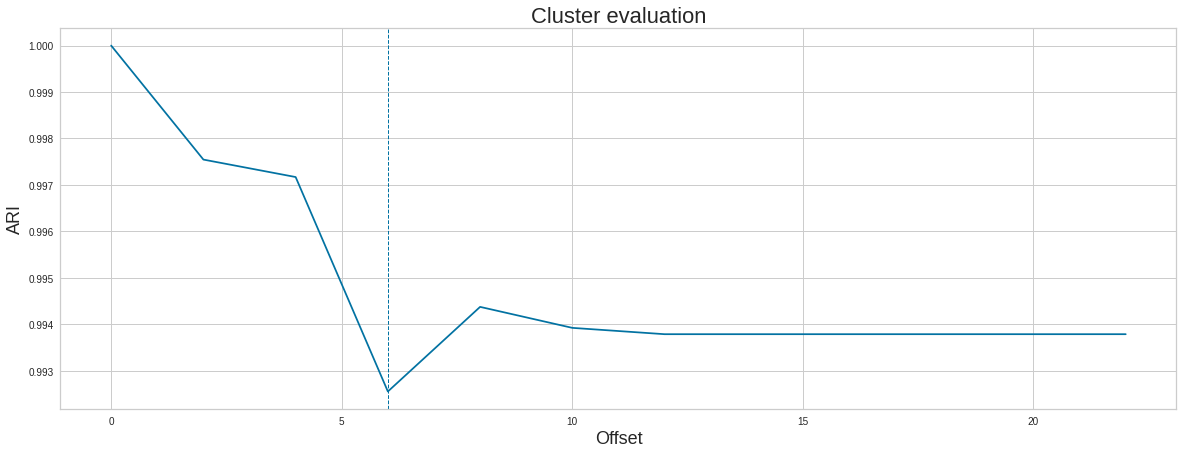

In [206]:
scores = pd.DataFrame(data=scores, columns=["offset", "ARI"])


plt.figure(figsize=(20, 7))
plt.title("Cluster evaluation", fontsize=22)
ax = sns.lineplot(data=scores, x="offset", y="ARI")

minima = scores.iloc[scores["ARI"].idxmin()]["offset"]
plt.axvline(minima, 0, scores["ARI"].max(), linestyle="--", linewidth=1)

plt.xlabel("Offset", fontsize=18)
plt.ylabel("ARI", fontsize=18)